# **Image Generator using <u>Conditional</u> Generative Adversarial Networks (cGANs)**
## <u>**Colored Arch**</u>
<br>

**Team Members:**
> - Seif Yasser <br>
> - Ahmed Nezar <br>
> - Kirolos Ehab <br>
> - Omar Bayomi <br>
> - AbdulRahman Hesham <br>

# Table of Contents
- [1 Imports](#imports)
- [2 Data Set](#eda)
  - [2.1 Data visualization](#visualization)
  - [2.2 Dataset](#Dataloader)
  - [2.3 Data set Splitting](#splitting)
- [3 Model](#model)
  - [3.1 Generator](#generator)
  - [3.2 Discriminator](#discriminator)
  - [3.3 Initialization](#Initialization)
- [4 Training Model](#training)


# Imports

In [48]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from PIL import Image
from torch import autograd
from torchvision.transforms import ToTensor, ToPILImage
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data import SubsetRandomSampler
import os
from sklearn.model_selection import train_test_split
from torchvision.io import read_image
from torch.nn.functional import adaptive_avg_pool2d
import torchvision.models as models
import torch.nn.functional as F
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from scipy import linalg
from torchviz import make_dot

In [38]:
from torchview import draw_graph

In [3]:
'cuda' if torch.cuda.is_available() else 'cpu'

'cuda'

In [17]:
torch.cuda.is_available()

True

# EDA

In [4]:
data='C:\\Users\\Seif Yasser\\Desktop\\Artificial intelligence\\Project\\Main-repo\\Image-Generation-Using-Generative-AI\\Shoes-Dataset-Colored'

In [19]:
def visualize_images(path):
    image_filenames = os.listdir(path)
    num_images = min(20, len(image_filenames))
    num_rows = num_images // 5 + (1 if num_images % 5 else 0)
    fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows))
    axes = axes.flatten() if num_rows > 1 else [axes]
    
    for i, image_filename in enumerate(image_filenames[:num_images]):
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)
        if len(image.shape) == 3 and image.shape[2] == 3:  
            image = image.mean(axis=2) 
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(image_filename, fontsize=8)


## Visualization

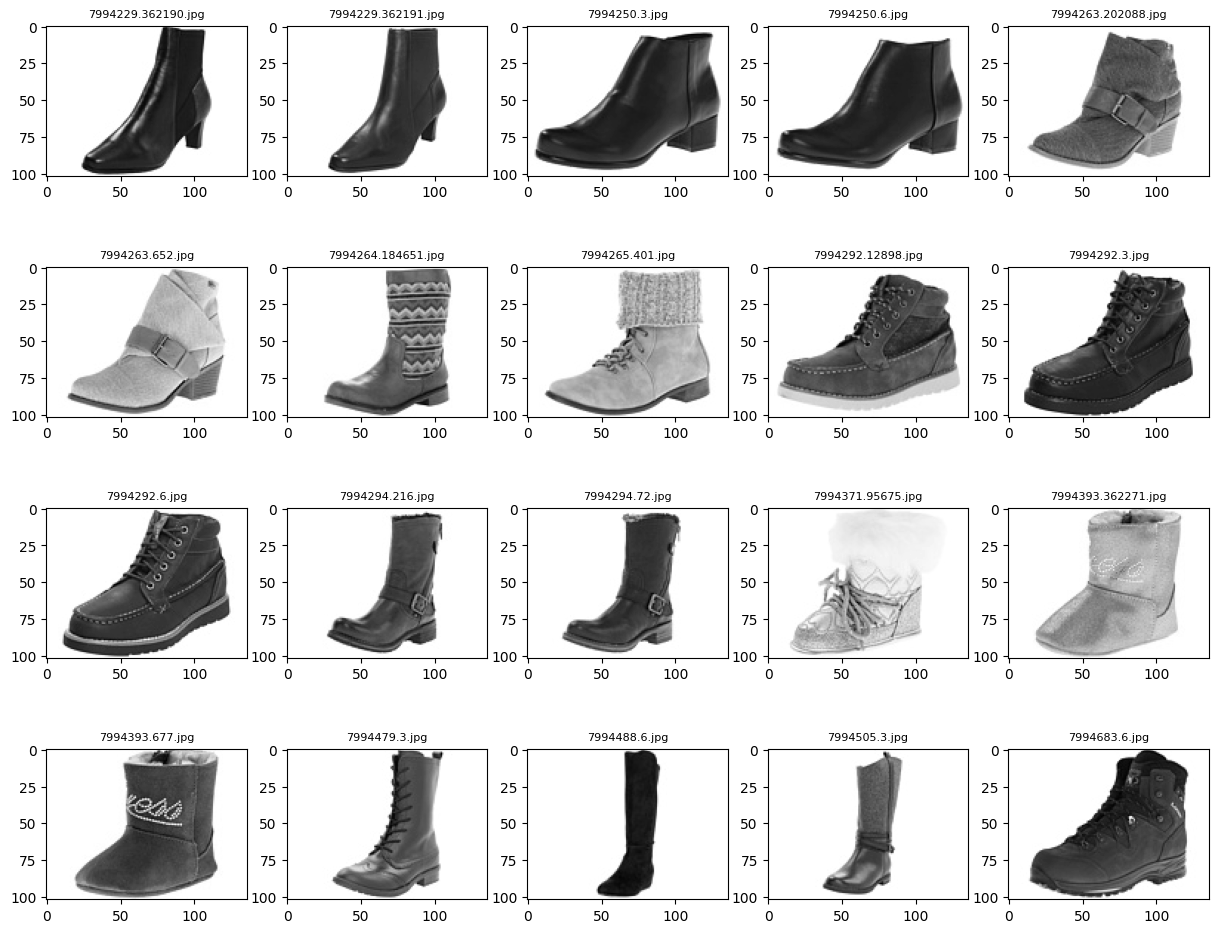

In [11]:
Boot_Dir = 'C:\\Users\\Seif Yasser\\Desktop\\Artificial intelligence\\Project\\Main-repo\\Image-Generation-Using-Generative-AI\\Shoes-Dataset-Colored\\Boot'
visualize_images(Boot_Dir)

In [ ]:
Sandal_Dir = 'Shoes-Dataset-Colored\\Sandal'
visualize_images(Sandal_Dir)

In [ ]:
Shoe_Dir = 'Shoes-Dataset-Colored\\Shoe'
visualize_images(Shoe_Dir)

In [9]:
img = Image.open(os.path.join(Boot_Dir, os.listdir(Boot_Dir)[0]))
img = np.array(img)
img.shape

(102, 136, 3)

## Dataloader

In [5]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    # transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
#    transforms.Normalize([0.5], [0.5])
])

In [6]:
Foot_Dataset = datasets.ImageFolder(data, transform=transform)
classes = Foot_Dataset.classes
print(classes)

['Boot', 'Sandal', 'Shoe']


In [13]:
Foot_Dataset

Dataset ImageFolder
    Number of datapoints: 15000
    Root location: Shoes-Dataset-Colored
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [8]:
Foot_Dataset.__len__()

15000

In [ ]:
for i in range(5):
    plt.imshow(Foot_Dataset[i][0].permute(1, 2, 0).cpu().numpy())
    plt.show()

## Splitting

In [22]:
train_size = int(0.8 * len(Foot_Dataset))
valid_size = len(Foot_Dataset) - train_size
train_ds, valid_ds = random_split(Foot_Dataset, [train_size, valid_size])

In [10]:
print("This is the size of Train Dataset:",train_ds.__len__())
print("This is the size of Validation Dataset:",valid_ds.__len__())

This is the size of Train Dataset: 25777
This is the size of Validation Dataset: 6445


In [11]:
print("This is the shape of Train Dataset:",train_ds[0][0].shape)
print("This is the shape of Train Dataset:",valid_ds[0][0].shape)

if  train_ds[0][0].shape == valid_ds[0][0].shape:
    print("\nTHEY ARE THE SAME SHAPE")

This is the shape of Train Dataset: torch.Size([3, 128, 128])
This is the shape of Train Dataset: torch.Size([3, 128, 128])

THEY ARE THE SAME SHAPE


# Model

In [23]:
batch_size=288

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size, shuffle=True)

## Generator

In [39]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 2048),
            nn.ReLU(True),
            nn.Linear(2048, 16384),  # Output size to match 128x128 image
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)  # Reshape to N x 3 x 128 x 128


## Descriminator

In [40]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(16384, 2048),  # Input size to match 128x128 image
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 16384)  # Flatten the image
        return self.disc(x)


In [41]:
gen=Generator(64)
disc=Discriminator()
gen.load_state_dict(torch.load('C:\\Users\\Seif Yasser\\Desktop\\Artificial intelligence\\Project\\Main-repo\\Image-Generation-Using-Generative-AI\\cGANs-Colored\\Notebooks\\cGANs-Arch-1-model750\\gen_750.pth'))

<All keys matched successfully>

In [42]:
mode_graph=draw_graph(gen,torch.randn(1,64),expand_nested=True,save_graph=True)


(dot.exe:33132): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


In [43]:
mode_graph_disc=draw_graph(disc,torch.randn(1,16384),expand_nested=True,roll=True,save_graph=True)


(dot.exe:38180): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.



(dot.exe:8340): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


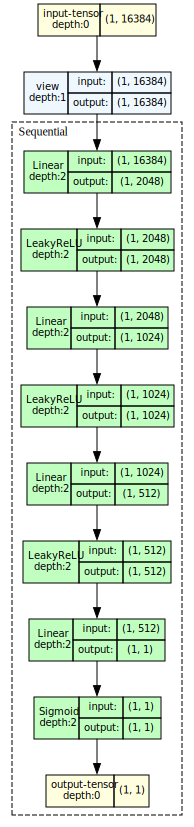

In [44]:
mode_graph_disc.visual_graph

In [36]:
mode_graph2=draw_graph(gen,torch.randn(1,64),expand_nested=True)


(dot.exe:21480): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


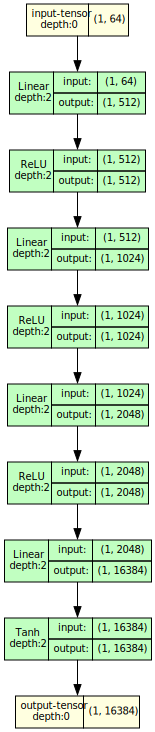

In [19]:
mode_graph.visual_graph


(dot.exe:36740): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


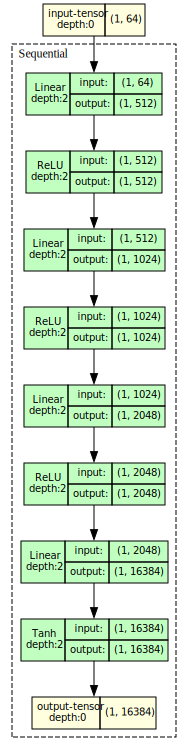

In [21]:
mode_graph2.visual_graph

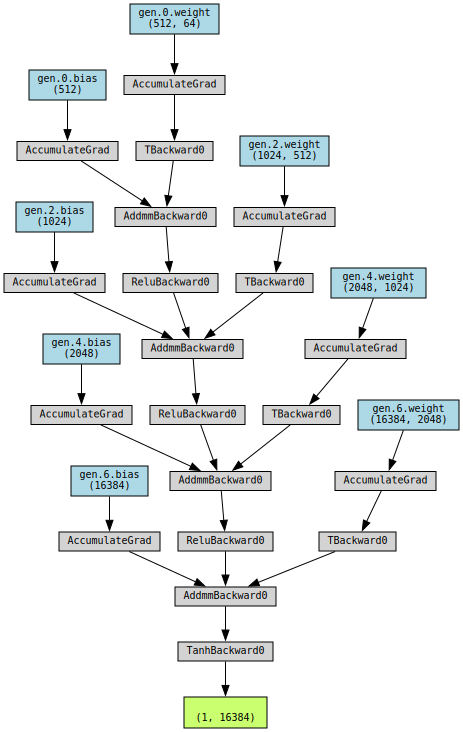

In [11]:
make_dot(gen(torch.randn(1, 64)), params=dict(gen.named_parameters()))

In [15]:
# print(torch.cuda.memory_allocated())
# print(torch.cuda.memory_cached())

# torch.cuda.empty_cache()

# print(torch.cuda.memory_allocated())
# print(torch.cuda.memory_cached())

## Initialization

In [65]:
z_dim = 64
gen = Generator(z_dim)
gen

Generator(
  (gen): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=2048, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=2048, out_features=16384, bias=True)
    (7): Tanh()
  )
)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [66]:
disc = Discriminator()
disc

Discriminator(
  (disc): Sequential(
    (0): Linear(in_features=16384, out_features=2048, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=512, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [158]:
train_loader.batch_size

256

In [29]:
def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [30]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [31]:
def calculate_fretchet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
     mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

In [33]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=False,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

c:\Users\Seif Yasser\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Seif Yasser\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [49]:
criterion = nn.BCELoss()
n_epochs = 500
z_dim = 64
display_step = 500
lr = 0.0002

In [50]:
lr = 0.0001

In [51]:
device='cuda'

In [52]:
gen = gen.to(device)
disc = disc.to(device)
criterion = criterion.to(device)

gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

In [54]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

def show_tensor_images(image_tensor, num_images=25, size=(3, 128, 128)):
    print(image_tensor.shape)
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0))
    plt.show()

def get_noise(n_samples, z_dim, device='cuda'):
    return torch.randn(n_samples, z_dim, device=device)


torch.Size([96, 16384])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


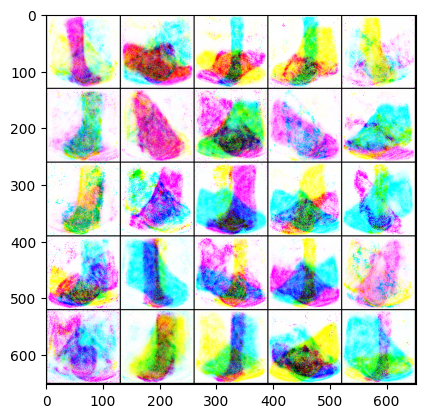

In [55]:
fake_noise =get_noise(96, 64).to(device)

fake = gen(fake_noise)

len(fake)
show_tensor_images(fake)

In [37]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True
gen_loss = False
error = False
generator_losses = []
discriminator_losses = []
fid_scores = []


In [28]:
writer_real = SummaryWriter(f"logs/real")
write_fake = SummaryWriter(f"logs/fake")

# Training

In [73]:
show_tensor_images(fake)

torch.Size([145, 16384])


RuntimeError: shape '[-1, 3, 128, 128]' is invalid for input of size 2375680

In [62]:
n_epochs=500

In [57]:
lr=1e-4

In [69]:
gen=Generator(z_dim)
gen.load_state_dict(torch.load('C:\\Users\\Seif Yasser\\Desktop\\Artificial intelligence\\Project\\Main-repo\\Image-Generation-Using-Generative-AI\\cGANs-Colored\\Notebooks\\cGANs-Arch-1-model250\\gen_250.pth'))
disc=Discriminator()
disc.load_state_dict(torch.load('C:\\Users\\Seif Yasser\\Desktop\\Artificial intelligence\\Project\\Main-repo\\Image-Generation-Using-Generative-AI\\cGANs-Colored\\Notebooks\\cGANs-Arch-1-model250\\disc_250.pth'))


<All keys matched successfully>

In [71]:

gen.to(device)
gen.float()
gen.eval()

disc.to(device)
disc.float()
disc.eval()

Discriminator(
  (disc): Sequential(
    (0): Linear(in_features=16384, out_features=2048, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=512, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [ ]:
for epoch in range(n_epochs):
    for real, _ in train_loader:
        cur_batch_size = len(real)
        real = real.to(device)
        noise= get_noise(cur_batch_size, z_dim, device=device)

        ### Update Discriminator ###
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        disc_loss.backward()
        
        # Apply gradient clipping to the discriminator
        torch.nn.utils.clip_grad_norm_(disc.parameters(), max_norm=1.0)
        disc_opt.step()

        ### Update Generator ###
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()

        # Apply gradient clipping to the generator
        torch.nn.utils.clip_grad_norm_(gen.parameters(), max_norm=1.0)
        gen_opt.step()
        discriminator_losses.append(disc_loss.item())
        generator_losses.append(gen_loss.item())

        ### Logging ###
        mean_discriminator_loss += disc_loss.item() / display_step
        mean_generator_loss += gen_loss.item() / display_step

        ### Visual Feedback and Logging ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch [{epoch+250}/{n_epochs+250}] Step {cur_step}: Generator loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
            with torch.no_grad():  # Temporarily set all the requires_grad flag to false
                gen.eval()
                fake_noise = get_noise(cur_batch_size, z_dim, device=device)
                fake = gen(fake_noise)
                show_tensor_images(fake)
                show_tensor_images(real)
                gen.train()
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        
        cur_step += 1

    plt.figure(figsize=(10, 5))
    plt.plot(discriminator_losses, label='Discriminator Loss')
    plt.plot(generator_losses, label='Generator Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Epoch {epoch+251}/{n_epochs+250}: Discriminator and Generator Losses')
    plt.legend()
    plt.show()
    with torch.no_grad():
        # fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(noise)
        real_reshaped = real.view(real.size(0), -1, 1, 1).to('cpu')  # Reshape real tensor to have spatial dimensions
        # fid = calculate_fretchet(real, fake, model)
        # fid_scores.append(fid)

        # Visualize FID
        # plt.figure(figsize=(10, 5))
        # plt.plot(range(epoch + 1), fid_scores, label='FID')
        # plt.xlabel('Epoch')
        # plt.ylabel('FID')
        # plt.title('FID Score')
        # plt.legend()
        # plt.show()
        # Print FID score
        # print(f"Epoch [{epoch+1}/{n_epochs}] FID: {fid:.4f}")
        
    if (epoch+251) % 1 == 0 or epoch == 0:
            gen.eval()
            noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(noise)
            img_grid_fake = make_grid(fake[:32], normalize=True)
            # plt.imshow(img_grid_fake.permute(1, 2, 0).cpu().numpy())
            # plt.show()
    if (epoch + 251) % 50 == 0:
        os.makedirs(f"cGANs-Arch-1-model{epoch+251}", exist_ok=True)
        
        # Visualize FID
        # plt.figure(figsize=(10, 5))
        # plt.plot(range(epoch + 1), fid_scores, label='FID')
        # plt.xlabel('Epoch')
        # plt.ylabel('FID')
        # plt.title('FID Score')
        # plt.legend()
        # plt.savefig(f"cDCGANs-Arch-4-model-modified-training{epoch+1}/fid_plot.png")
        
        plt.figure(figsize=(10, 5))
        plt.plot(discriminator_losses, label='Discriminator Loss')
        plt.plot(generator_losses, label='Generator Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title(f'Epoch {epoch+251}/{n_epochs+250}: Discriminator and Generator Losses')
        plt.legend()
        plt.savefig(f"cGANs-Arch-1-model{epoch+251}/losses_plot.png")        
        
        plt.imsave(f"cGANs-Arch-1-model{epoch+251}/fake_{epoch+251}.png", img_grid_fake.permute(1, 2, 0).cpu().numpy())
        # Save evaluation metrics
        # evaluation_metrics = {"FID": fid_scores[-1]}
        # torch.save(evaluation_metrics, f"cGANs-Arch-1-model{epoch+1}/evaluation_metrics.pth")
        # Save generator, discriminator, and optimizers
        torch.save(gen.state_dict(), f"cGANs-Arch-1-model{epoch+251}/gen_{epoch+251}.pth")
        torch.save(disc.state_dict(), f"cGANs-Arch-1-model{epoch+251}/disc_{epoch+251}.pth")
        torch.save(gen_opt.state_dict(), f"cGANs-Arch-1-model{epoch+251}/opt_gen_{epoch+251}.pth")
        torch.save(disc_opt.state_dict(), f"cGANs-Arch-1-model{epoch+251}/opt_disc_{epoch+251}.pth")

        # Save losses and evaluation scores to files
        torch.save(discriminator_losses, f"cGANs-Arch-1-model{epoch+101}/losses_disc.pth")
        torch.save(generator_losses, f"cGANs-Arch-1-model{epoch+101}/losses_gen.pth")
        # torch.save(fid_scores, f"cGANs-Arch-model{epoch+1}/fid_scores.pth")
    
    


In [179]:
# Save the model
# torch.save(gen.state_dict(), 'gen_500_epochs.pth')
# torch.save(disc.state_dict(), 'disc_500_epochs.pth')

In [ ]:
# Save model checkpoints periodically or based on performance
#torch.save(disc.state_dict(), 'disc_750_epochs.pth')
#torch.save(gen.state_dict(), 'gen_750_epochs.pth')